In [4]:
!pip install spacy pandas
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_trf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 77.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

In [5]:
import pandas as pd
import spacy
from spacy import displacy
from collections import Counter


In [11]:
def read_conll_file(filepath):
    sentences = []
    sentence = []
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            elif line.startswith("-DOCSTART-"):  # skip this line
                continue
            else:
                parts = line.split()
                if len(parts) == 4:
                    word, pos, chunk, ner = parts
                    sentence.append((word, pos, chunk, ner))
    if sentence:
        sentences.append(sentence)
    return sentences



train_sentences = read_conll_file("/kaggle/input/conll003-englishversion/train.txt")
val_sentences = read_conll_file("/kaggle/input/conll003-englishversion/valid.txt")
test_sentences = read_conll_file("/kaggle/input/conll003-englishversion/test.txt")

print("Train sentences:", len(train_sentences))
print("Validation sentences:", len(val_sentences))
print("Test sentences:", len(test_sentences))


Train sentences: 14041
Validation sentences: 3250
Test sentences: 3453


# Convert Sentences to Text

In [12]:
def sentences_to_text(sentences):
    return [" ".join([word for word, _, _, _ in sent]) for sent in sentences]

train_texts = sentences_to_text(train_sentences)
val_texts   = sentences_to_text(val_sentences)
test_texts  = sentences_to_text(test_sentences)


# Load SpaCy Models

In [13]:
nlp_sm  = spacy.load("en_core_web_sm")  
nlp_trf = spacy.load("en_core_web_trf") 

# Extract Named Entities

In [15]:
def extract_entities(text, model):
    doc = model(text)
    return [(ent.text, ent.label_) for ent in doc.ents]


sample_text = train_texts[0]
entities_sm  = extract_entities(sample_text, nlp_sm)
entities_trf = extract_entities(sample_text, nlp_trf)

print("Sample SM entities:", entities_sm)
print("Sample TRF entities:", entities_trf)


Sample SM entities: [('EU', 'ORG'), ('German', 'NORP'), ('British', 'NORP')]
Sample TRF entities: [('EU', 'ORG'), ('German', 'NORP'), ('British', 'NORP')]


# Visualize Entities

In [17]:
displacy.render(nlp_sm(sample_text), style="ent", jupyter=True)
displacy.render(nlp_trf(sample_text), style="ent", jupyter=True)


# Extract Entities for All Splits

In [18]:
def extract_entities_list(texts, model):
    return [extract_entities(text, model) for text in texts]

# Train
train_entities_sm  = extract_entities_list(train_texts, nlp_sm)
train_entities_trf = extract_entities_list(train_texts, nlp_trf)

# Validation
val_entities_sm  = extract_entities_list(val_texts, nlp_sm)
val_entities_trf = extract_entities_list(val_texts, nlp_trf)

# Test
test_entities_sm  = extract_entities_list(test_texts, nlp_sm)
test_entities_trf = extract_entities_list(test_texts, nlp_trf)


# Bonus:
*    # Compare results using two different spaCy model
*    # Visualize extracted entities with displacy 

# Compare Entity Counts

In [20]:
def entity_counter(entities_list):
    labels = [label for sentence in entities_list for _, label in sentence]
    return Counter(labels)


print("Train entity counts (SM):", entity_counter(train_entities_sm))
print("Train entity counts (TRF):", entity_counter(train_entities_trf))


print("Validation entity counts (SM):", entity_counter(val_entities_sm))
print("Validation entity counts (TRF):", entity_counter(val_entities_trf))


print("Test entity counts (SM):", entity_counter(test_entities_sm))
print("Test entity counts (TRF):", entity_counter(test_entities_trf))


Train entity counts (SM): Counter({'CARDINAL': 6578, 'GPE': 6158, 'DATE': 5972, 'PERSON': 5949, 'ORG': 4731, 'NORP': 2011, 'ORDINAL': 994, 'MONEY': 634, 'QUANTITY': 424, 'TIME': 424, 'PERCENT': 318, 'PRODUCT': 307, 'LOC': 209, 'EVENT': 165, 'FAC': 160, 'WORK_OF_ART': 87, 'LAW': 77, 'LANGUAGE': 27})
Train entity counts (TRF): Counter({'CARDINAL': 7931, 'GPE': 7530, 'PERSON': 6879, 'DATE': 5091, 'ORG': 3871, 'NORP': 2131, 'ORDINAL': 1171, 'MONEY': 743, 'TIME': 501, 'QUANTITY': 415, 'EVENT': 409, 'PERCENT': 368, 'LOC': 241, 'FAC': 204, 'PRODUCT': 128, 'WORK_OF_ART': 72, 'LANGUAGE': 24, 'LAW': 20})
Validation entity counts (SM): Counter({'CARDINAL': 1707, 'GPE': 1605, 'PERSON': 1568, 'DATE': 1505, 'ORG': 991, 'NORP': 562, 'ORDINAL': 267, 'MONEY': 140, 'TIME': 104, 'QUANTITY': 88, 'PERCENT': 80, 'EVENT': 76, 'LOC': 71, 'PRODUCT': 52, 'FAC': 43, 'WORK_OF_ART': 32, 'LAW': 23, 'LANGUAGE': 11})
Validation entity counts (TRF): Counter({'CARDINAL': 2053, 'PERSON': 1890, 'GPE': 1886, 'DATE': 1318,

In [22]:
train_df = pd.DataFrame({
    "text": train_texts,
    "entities_sm": train_entities_sm,
    "entities_trf": train_entities_trf
})

val_df = pd.DataFrame({
    "text": val_texts,
    "entities_sm": val_entities_sm,
    "entities_trf": val_entities_trf
})

test_df = pd.DataFrame({
    "text": test_texts,
    "entities_sm": test_entities_sm,
    "entities_trf": test_entities_trf
})


In [26]:
for i in range(3):
    print(f"\n Train Sentence {i+1} (SM model)")
    displacy.render(nlp_sm(train_texts[i]), style="ent", jupyter=True)
    
    print(f"\n Train Sentence {i+1} (TRF model)")
    displacy.render(nlp_trf(train_texts[i]), style="ent", jupyter=True)



 Train Sentence 1 (SM model)



 Train Sentence 1 (TRF model)



 Train Sentence 2 (SM model)



 Train Sentence 2 (TRF model)



 Train Sentence 3 (SM model)



 Train Sentence 3 (TRF model)


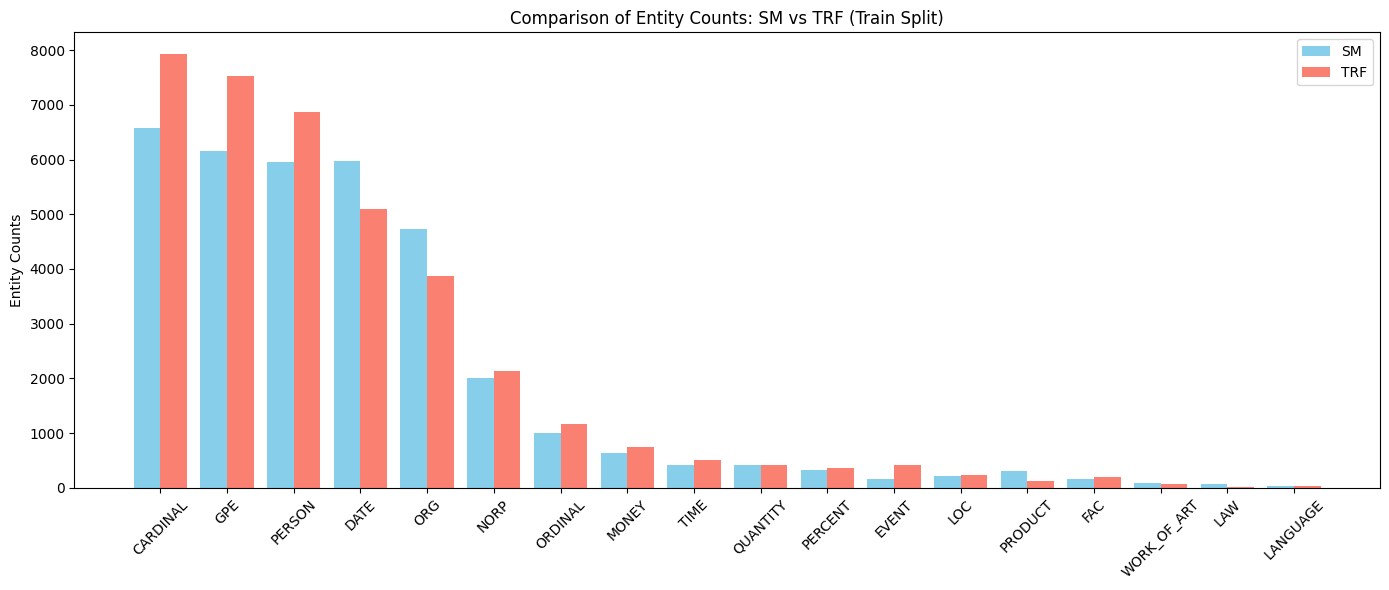

In [28]:

train_counts_sm  = entity_counter(train_entities_sm)
train_counts_trf = entity_counter(train_entities_trf)

df_plot = pd.DataFrame({
    "Entity": list(train_counts_sm.keys()),
    "SM_Count": list(train_counts_sm.values()),
    "TRF_Count": [train_counts_trf.get(k, 0) for k in train_counts_sm.keys()]
})

df_plot["Total"] = df_plot["SM_Count"] + df_plot["TRF_Count"]
df_plot = df_plot.sort_values(by="Total", ascending=False)

plt.figure(figsize=(14,6))
bar_width = 0.4
indices = range(len(df_plot))

plt.bar(indices, df_plot["SM_Count"], width=bar_width, label="SM", color="skyblue")
plt.bar([i + bar_width for i in indices], df_plot["TRF_Count"], width=bar_width, label="TRF", color="salmon")

plt.xticks([i + bar_width/2 for i in indices], df_plot["Entity"], rotation=45)
plt.ylabel("Entity Counts")
plt.title("Comparison of Entity Counts: SM vs TRF (Train Split)")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
train_df.to_csv("train_ner.csv", index=False)
val_df.to_csv("val_ner.csv", index=False)
test_df.to_csv("test_ner.csv", index=False)
